## Mapping Climate Data

In this example we will display temperature data as a heat map. The data is imported as a .nc file which is common for climate data files with geographic and climate information. 

This example is the temperature at a single temperature level, for a single hour of a single day for the globe. 

In [1]:
# Requirements: 
# NetCDF4 (http://unidata.github.io/netcdf4-python/)
# Basemap (https://matplotlib.org/basemap/)

In [20]:
# Utilities
import os
import datetime as datetime
import io
import base64

# Numerics
import numpy as np

# For reading a .nc file
import netCDF4 as nc4
from netCDF4 import Dataset, num2date, date2index

# For mapping
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
from matplotlib import colors as c

# For animstion
from IPython.display import HTML
import imageio

In [3]:
file_path = os.path.join(".")
netcdf_file = "adaptor.mars.internal-1546521808.575769-20847-3-4e207384-5921-4aae-acd9-b81fe4d68404.nc"

In [4]:
# 1. Read in .nc file using NetCDF
f = Dataset(os.path.join(file_path,netcdf_file),mode = 'r')

In [5]:
# Show info about file: 
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT data model, file format UNDEFINED):
    Conventions: CF-1.6
    history: 2019-01-03 13:23:29 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -o /cache/data1/adaptor.mars.internal-1546521808.575769-20847-3-4e207384-5921-4aae-acd9-b81fe4d68404.nc /cache/tmp/4e207384-5921-4aae-acd9-b81fe4d68404-adaptor.mars.internal-1546521808.5761547-20847-1-tmp.grib
    dimensions(sizes): longitude(1440), latitude(721), time(1)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t(time,latitude,longitude)
    groups: 



In [6]:
for d in f.dimensions.items():
    print(d)

('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 1440
)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 721
)
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
)


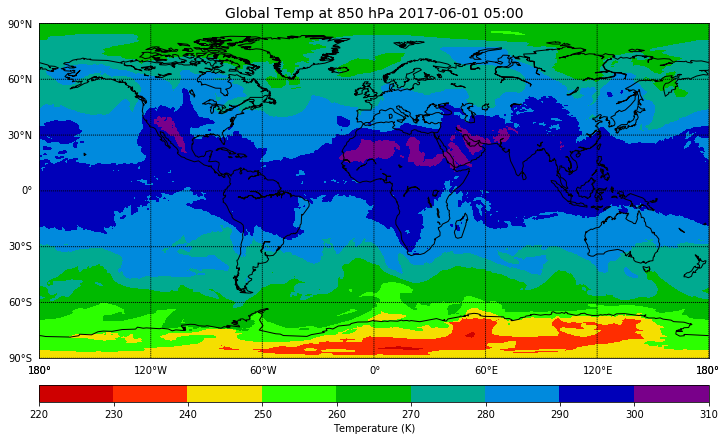

In [15]:
# Now let's plot it!

lats = f.variables['latitude'][:]
lons = f.variables['longitude'][:]

#t(time,latitude,longitude)->t[0,:,:]
temp = f.variables['t'][0,:,:]#<-This part will change if your .nc file has more variables. Put [0s] for any thing other than lat,long

# Create my plot (Standard matplot lib)
fig = plt.figure(figsize=[12,15])  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
ax.set_title('Global Temp at 850 hPa 2017-06-01 05:00', fontsize=14)

# Define my map:
map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c', ax=ax) #Resolutions: c: crude, l: low

# Add details to map: 
map.drawcoastlines()
map.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

# Need to do a bit of transformation to our data before it can be plotted. 
# shift data so lons go from -180 to 180 instead of 0 to 360.
temp,lons = shiftgrid(180.,temp,lons,start=False)
llons, llats = np.meshgrid(lons, lats)
x,y = map(llons,llats)

# Plot the data on the map
cs = map.contourf(x,y,temp,cmap=plt.cm.get_cmap('nipy_spectral_r'))
cb = map.colorbar(cs,"bottom",size = "5%",pad = "8%")

cb.set_label("Temperature (K)")

In [16]:
# Same day/time for last 10 years: 
filepath = "adaptor.mars.internal-1546523781.7466927-846-7-234880c7-0769-44e8-8bdb-f52b6f0602b7.nc"
fh = Dataset(os.path.join(file_path,filepath),mode = 'r')
times = fh.variables['time']
dates = num2date(times[:], times.units)
print(dates)

[datetime.datetime(2007, 6, 1, 5, 0) datetime.datetime(2008, 6, 1, 5, 0)
 datetime.datetime(2009, 6, 1, 5, 0) datetime.datetime(2010, 6, 1, 5, 0)
 datetime.datetime(2011, 6, 1, 5, 0) datetime.datetime(2012, 6, 1, 5, 0)
 datetime.datetime(2013, 6, 1, 5, 0) datetime.datetime(2014, 6, 1, 5, 0)
 datetime.datetime(2015, 6, 1, 5, 0) datetime.datetime(2016, 6, 1, 5, 0)
 datetime.datetime(2017, 6, 1, 5, 0)]


In [17]:
def make_png(year,f):
    year_index= date2index(datetime.datetime(year,6,1),times,select = 'nearest')
    lats = f.variables['latitude'][:]
    lons = f.variables['longitude'][:]
    temp = f.variables['t'][year_index,:,:]
    
    # Create my plot (Standard matplot lib)
    fig = plt.figure(figsize=[12,15])  # a new figure window
    ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
    title = 'Global Temp at 850 hPa %s-06-01 05:00'%year
    ax.set_title(title, fontsize=14)

    # Define my map:
    map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                llcrnrlon=-180,urcrnrlon=180,resolution='c', ax=ax) #Resolutions: c: crude, l: low

    # Add details to map: 
    map.drawcoastlines()
    map.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,0])
    map.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,0,1])

    # Need to do a bit of transformation to our data before it can be plotted. 
    # shift data so lons go from -180 to 180 instead of 0 to 360.
    temp,lons = shiftgrid(180.,temp,lons,start=False)
    llons, llats = np.meshgrid(lons, lats)
    x,y = map(llons,llats)
    
    # Define standard temperature scale
    cmap = c.ListedColormap(['#000080','#004cff',
                         '#0099ff','#00d900','#73ffff', 
                         '#ffff00','#ff9900','#ff6600',
                         '#ff2600','#4c0000'])
    bounds = [220,230,240,250,260,270,280,290,300,310,320]
    norm = c.BoundaryNorm(bounds,ncolors = cmap.N)
    # Plot the data on the map
    cs = map.contourf(x,y,temp,cmap=cmap,norm = norm,levels = bounds)
    fig.colorbar(cs,cmap=cmap,norm = norm, boundaries=bounds,ticks = bounds,orientation = 'horizontal')
    
    cb.set_label("Temperature (K)")
    filename = title + '.png'
    fig.savefig(filename)
    return filename

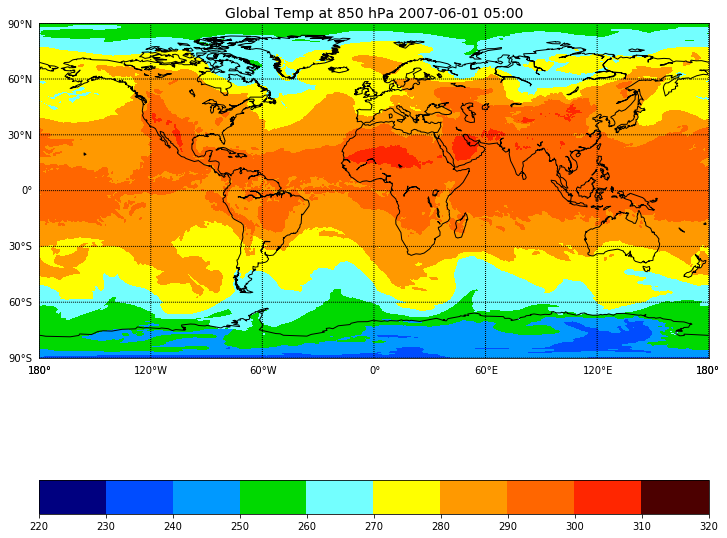

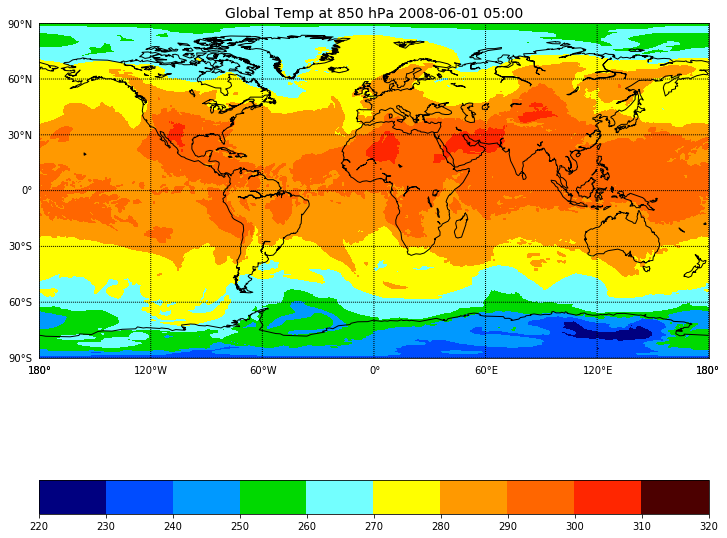

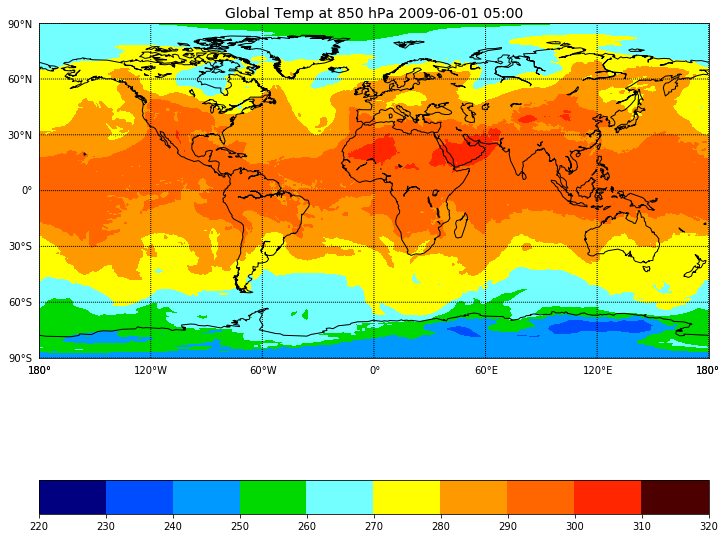

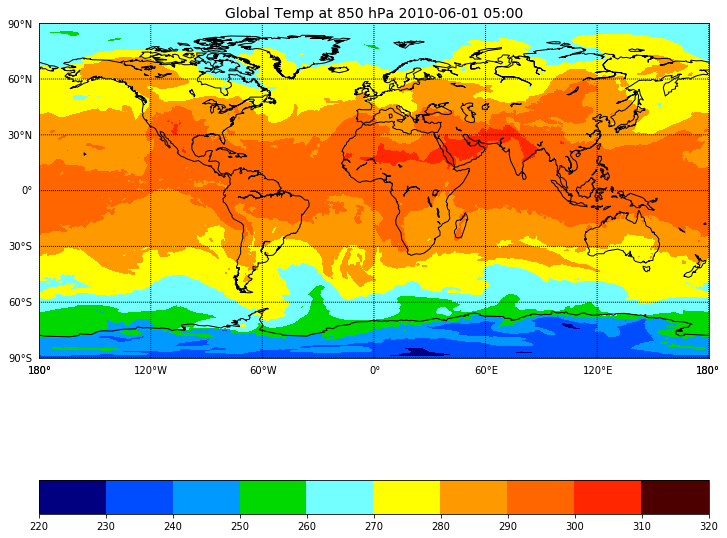

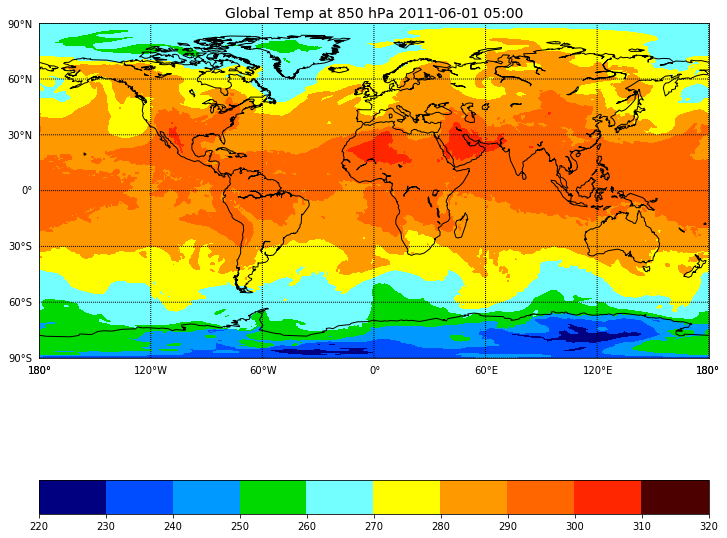

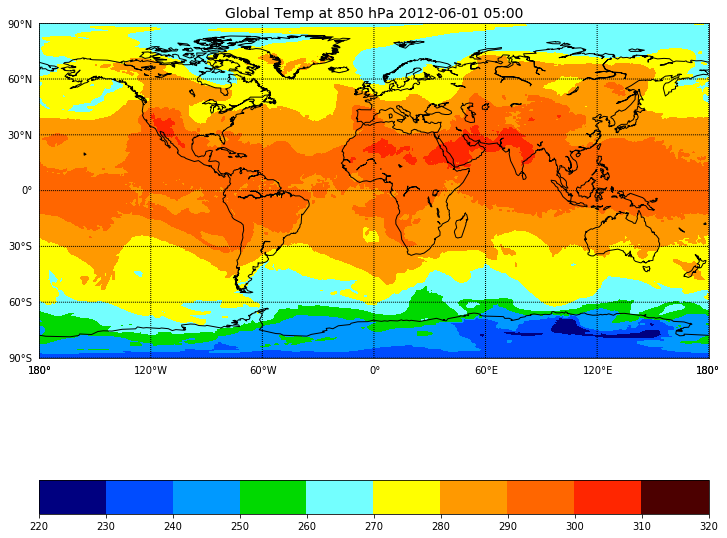

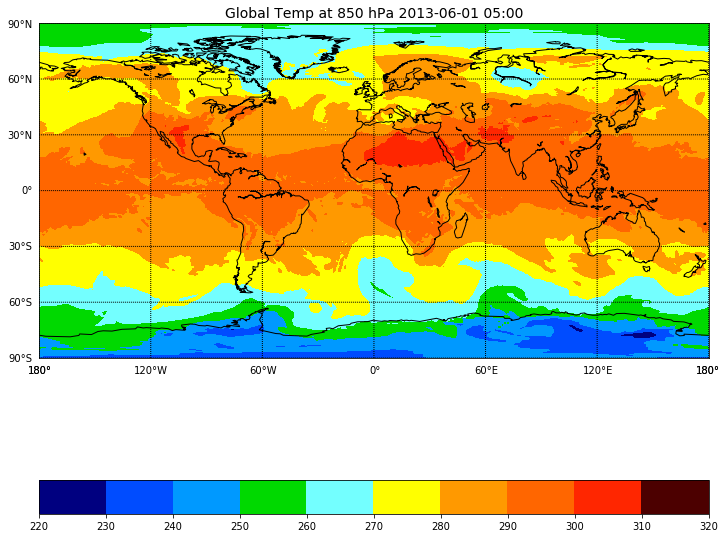

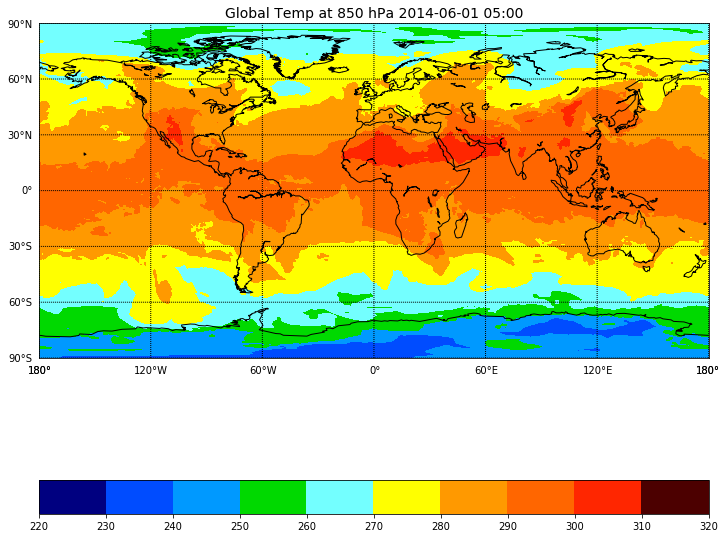

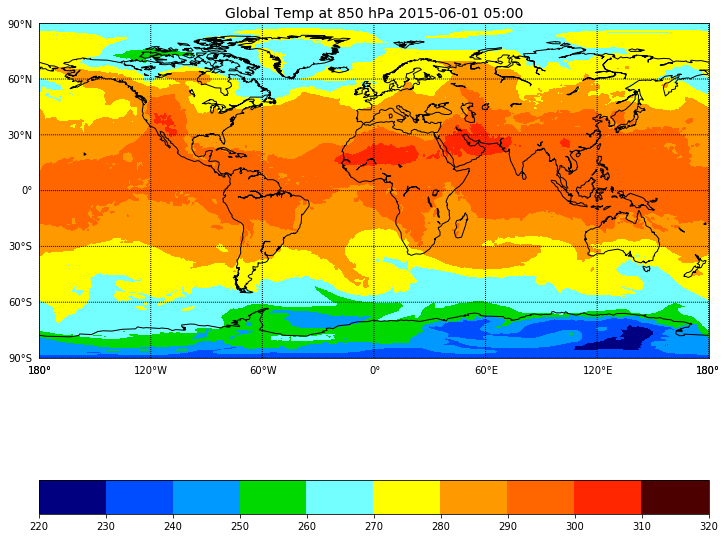

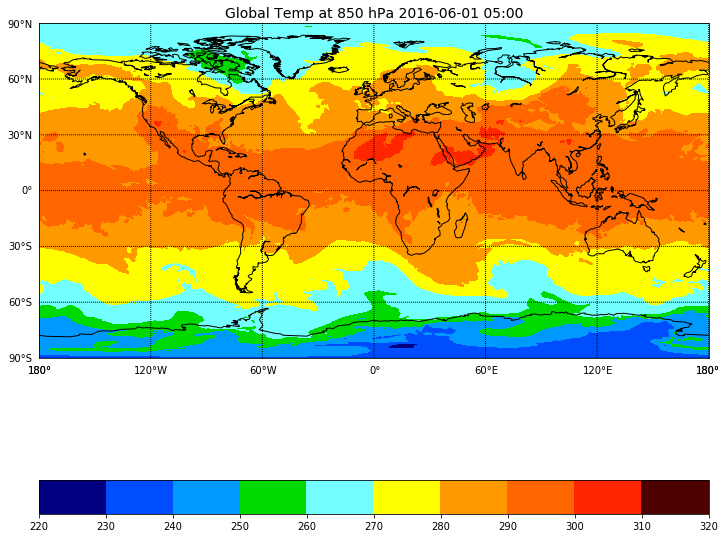

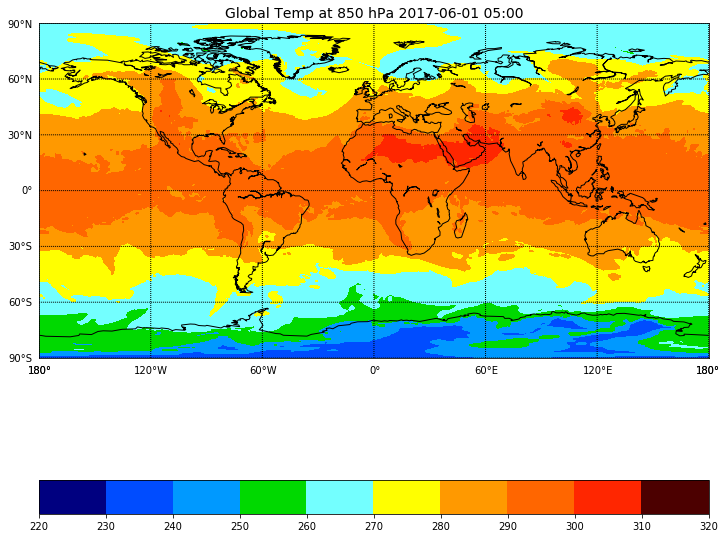

In [11]:
filenames = [make_png(year.year,fh) for year in dates]


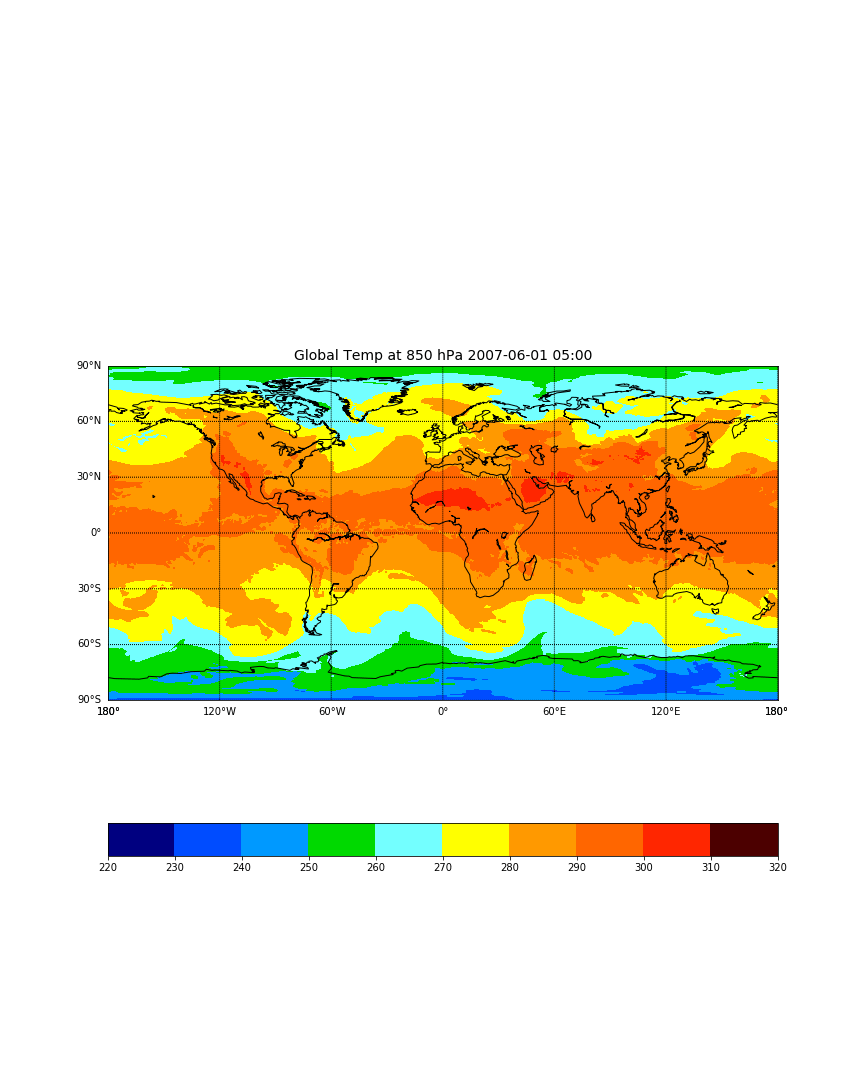

In [18]:
# Make an animation!

gif_name = 'animation.gif'

with imageio.get_writer(gif_name, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
video = io.open(gif_name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))